In [3]:
import imutils
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import cv2

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"E:\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

print("[INFO] loading images...")
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


[INFO] loading images...


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 8s 1us/step


In [6]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [7]:
print("[INFO] compiling model...")
import tensorflow as tf
opt = tf.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] compiling model...
[INFO] training head...


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
95/95 [==============================] - 171s 2s/step - loss: 0.3751 - accuracy: 0.8606 - val_loss: 0.1355 - val_accuracy: 0.9844
Epoch 2/20
95/95 [==============================] - 196s 2s/step - loss: 0.1369 - accuracy: 0.9670 - val_loss: 0.0716 - val_accuracy: 0.9883
Epoch 3/20
95/95 [==============================] - 132s 1s/step - loss: 0.0852 - accuracy: 0.9779 - val_loss: 0.0517 - val_accuracy: 0.9896
Epoch 4/20
95/95 [==============================] - 135s 1s/step - loss: 0.0734 - accuracy: 0.9769 - val_loss: 0.0441 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 134s 1s/step - loss: 0.0598 - accuracy: 0.9812 - val_loss: 0.0389 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 136s 1s/step - loss: 0.0594 - accuracy: 0.9819 - val_loss: 0.0383 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 127s 1s/step - loss: 0.0443 - accuracy: 0.9868 - val_loss: 0.0338 - val_accuracy: 0.9909
Epoch 8/20
95

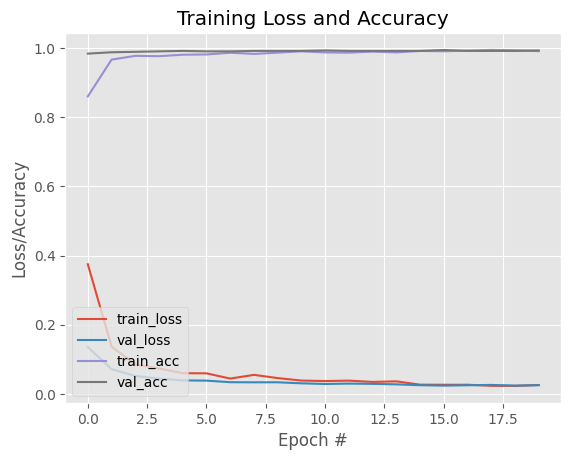

In [8]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os
def detect_and_predict_mask(frame, faceNet, maskNet):
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		confidence = detections[0, 0, i, 2]
		if confidence > 0.5:
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			faces.append(face)
			locs.append((startX, startY, endX, endY))

	if len(faces) > 0:
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	return (locs, preds)

prototxtPath = r"E:\Face-Mask-Detection-master\face_detector\deploy.prototxt"
weightsPath = r"E:\Face-Mask-Detection-master\face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

maskNet = load_model("mask_detector.model")

print("[INFO] starting video stream...")
vs = VideoStream(src=1).start()

while True:
	frame = vs.read()
	frame = imutils.resize(frame, width=400)
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
	for (box, pred) in zip(locs, preds):
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	cv2.imshow("LIVE", frame)
	key = cv2.waitKey(10)

	if key == 27: 
		break
vs.release()
cv2.destroyAllWindows()


[INFO] starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 4s 4s/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 99ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 138ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 132ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 115ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 128ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 110ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 108ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 85ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 91ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 88ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 86ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 77ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 90ms/step
(1, 1, 200,

KeyboardInterrupt: 